1. Get meal plan

In [114]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

#meal plan page(can just change the number at end of link to see different meal plans)
URL = "https://tastesbetterfromscratch.com/meal-plan-194/"

#get HTML from site
resp = requests.get(URL, headers={"User-Agent": "Mozilla/5.0"})
soup = BeautifulSoup(resp.text, "html.parser")

rows = []

#find all <p> tags with class="has-text-align-left"
for p in soup.find_all("p", class_="has-text-align-left"):
    day_tag = p.find("strong") #<strong> for day name
    link_tag = p.find("a", href=True) #<a> tag for recipe name + link

    day = day_tag.get_text(strip=True).rstrip(":") #cleaned day name
    name = link_tag.get_text(strip=True) #recipe name
    link = link_tag["href"] #recipe link

    price = p.get_text(" ", strip=True) #gets all text in the <p> tag string
    dollarsign = re.search(r'\$\d+', price) #searches for dollar sign followed by numbers
    newprice = dollarsign.group(0) if dollarsign else "" #extract text if a dollarsign is found otherwise move on

    rows.append({
        "Day of the Week": day,
        "Name of Recipe": name,
        "Link to Recipe": link,
        "Price of Recipe": newprice
    })

df = pd.DataFrame(rows, columns=["Day of the Week", "Name of Recipe", "Link to Recipe", "Price of Recipe"])
df


,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe
0,Monday,Ground Beef Tacos,https://tastesbetterfromscratch.com/ground-bee...,$11
1,Tuesday,Chow Mein,https://tastesbetterfromscratch.com/chinese-ch...,$10
2,Wednesday,Patty Melt,https://tastesbetterfromscratch.com/patty-melt/,$18
3,Thursday,Chicken and Dumplings,https://tastesbetterfromscratch.com/chicken-an...,$14
4,Friday,Veggie Wrap,https://tastesbetterfromscratch.com/hummus-eda...,$9


2. Find matching recipes to Monday day in meal plan

In [115]:
monday_recipe = df.loc[df["Day of the Week"] == "Monday", "Name of Recipe"].iloc[0] #get monday recipe

url = "https://tasty.p.rapidapi.com/recipes/list"
headers = {
    "X-RapidAPI-Key": "15bb89a7d5msh77e6b47794d9502p11b4c9jsn11ec5a5d43b4",
    "X-RapidAPI-Host": "tasty.p.rapidapi.com"
}

params = {"from": "0", "size": "100", "q": monday_recipe}
response = requests.get(url, headers=headers, params=params)

#normalize JSON and keep only recipe names
data = response.json()
results = data.get("results", [])
df_results = pd.json_normalize(results)
df_results["name"]


,name
0,Taco Soup
1,Taco-Stuffed Peppers
2,One-Pot Taco Spaghetti
3,One-Pot Cheesy Taco Pasta
4,Crunchy Taco Cups
5,Slow Cooker Barbacoa-Style Beef Tacos
6,One-Pan Taco Macaroni And Cheese
7,Beef & Bean Burritos
8,Weekday Meal-Prep Turkey Taco Bowls
9,Taco Lasagna


Code I was testing with to find the matches and original recipe for each day of the meal plan

In [116]:
url = "https://tasty.p.rapidapi.com/recipes/list"
headers = {
    "X-RapidAPI-Key": "15bb89a7d5msh77e6b47794d9502p11b4c9jsn11ec5a5d43b4",
    "X-RapidAPI-Host": "tasty.p.rapidapi.com"
}

alldays = df["Day of the Week"].unique()
all_frames = []

for day in alldays:
    recipe_name = df.loc[df["Day of the Week"] == day, "Name of Recipe"].iloc[0]

    original_df = pd.DataFrame([{"Day of the Week": day,"Name of Recipe": recipe_name}]) #makes df of original recipes for each day

    params = {"from": "0", "size": "100", "q": recipe_name}
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    results = data.get("results", [])
    df_results = pd.json_normalize(results)

    if "name" in df_results.columns:
        df_results = df_results[["name"]].rename(columns={"name": "Name of Recipe"}) #renames to match original df
        df_results["Day of the Week"] = day #adds day column we need
    else:
        df_results = pd.DataFrame(columns=["Day of the Week", "Name of Recipe"]) #just makes empty df in case there no matches

    combined_day = pd.concat([original_df, df_results], ignore_index=True) #combine original + matches for the day
    all_frames.append(combined_day) #adds everything to the original empty list we made

# combine all days
df_all = pd.concat(all_frames, ignore_index=True) #adds together everything in list into a dataframe
df_all

,Day of the Week,Name of Recipe
0,Monday,Ground Beef Tacos
1,Monday,Taco Soup
2,Monday,Taco-Stuffed Peppers
3,Monday,One-Pot Taco Spaghetti
4,Monday,One-Pot Cheesy Taco Pasta
...,...,...
122,Friday,Bacon-wrapped Mashed Potato-stuffed Meatloaf
123,Friday,Sausage-wrapped Soft Boiled Egg (Scotch Egg)
124,Friday,Homemade Dumplings
125,Friday,"Tomato, Mushroom, And Zucchini Zucchini-Wrappe..."


3. Function to get the meal plan information and matching recipes

In [117]:
#combine code from before
def get_mealplan_data(plan_number):
    #meal plan page (change the number at end of link to see different meal plans)
    URL = f"https://tastesbetterfromscratch.com/meal-plan-{plan_number}/"

    #get HTML from site
    resp = requests.get(URL, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(resp.text, "html.parser")

    rows = []

    #find all <p> tags with class="has-text-align-left"
    for p in soup.find_all("p", class_="has-text-align-left"):
        day_tag = p.find("strong") #<strong> for day name
        link_tag = p.find("a", href=True) #<a> tag for recipe name + link

        day = day_tag.get_text(strip=True).rstrip(":") #cleaned day name
        name = link_tag.get_text(strip=True) #recipe name
        link = link_tag["href"] #recipe link

        price = p.get_text(" ", strip=True) #gets all text in the <p> tag string
        dollarsign = re.search(r'\$\d+', price) #searches for dollar sign followed by numbers
        newprice = dollarsign.group(0) if dollarsign else "" #extract text if a dollarsign is found otherwise move on

        rows.append({
            "Day of the Week": day,
            "Name of Recipe": name,
            "Link to Recipe": link,
            "Price of Recipe": newprice,
            "Source": "Meal Plan Recipe"
        })

    df = pd.DataFrame(rows, columns=["Day of the Week", "Name of Recipe", "Link to Recipe", "Price of Recipe", "Source"])



    #start of matching recipe section similar to monday code
    url = "https://tasty.p.rapidapi.com/recipes/list"
    headers = {
        "X-RapidAPI-Key": "15bb89a7d5msh77e6b47794d9502p11b4c9jsn11ec5a5d43b4",
        "X-RapidAPI-Host": "tasty.p.rapidapi.com"
    }

    alldays = df["Day of the Week"].unique()#all unique days
    all_frames = []
    keep_fields = ["name", "slug", "canonical_id", "cook_time_minutes", "prep_time_minutes", "is_shoppable",#all the columns i want to keep
        "user_ratings.score", "user_ratings.count_positive", "user_ratings.count_negative",
        "nutrition.calories", "nutrition.fat", "nutrition.protein", "nutrition.carbohydrates",
        "nutrition.fiber", "nutrition.sugar", "tags"]

    for day in alldays:
        recipe_name = df.loc[df["Day of the Week"] == day, "Name of Recipe"].iloc[0]
        recipe_price = df.loc[df["Day of the Week"] == day, "Price of Recipe"].iloc[0]
        recipe_link  = df.loc[df["Day of the Week"] == day, "Link to Recipe"].iloc[0]

        original_df = pd.DataFrame([{ #all the columns we want to keep
            "Day of the Week": day,
            "Name of Recipe": recipe_name,
            "Source": "Meal Plan Recipe",
            "Price of Recipe": recipe_price,
            "Link to Recipe": recipe_link,
            "cook_time_minutes": "",
            "prep_time_minutes": "",
            "is_shoppable": "",
            "user_ratings.score": "",
            "user_ratings.count_positive": "",
            "user_ratings.count_negative": "",
            "nutrition.calories": "",
            "nutrition.fat": "",
            "nutrition.protein": "",
            "nutrition.carbohydrates": "",
            "nutrition.fiber": "",
            "nutrition.sugar": "",
            "tags": ""
        }])

        #searching Tasty API
        params = {"from": "0", "size": "100", "q": recipe_name}
        response = requests.get(url, headers=headers, params=params)
        data = response.json()
        results = data.get("results", [])
        df_results = pd.json_normalize(results)

        #keep only relevant columns if they exist
        available_fields = [f for f in keep_fields if f in df_results.columns] #keeps only the columns we want and checks through them
        if available_fields:
          df_results = df_results[available_fields]

          #drop compilations/lists, keep only singular recipes, gets rid of things like 5 fingerless foods
          if "canonical_id" in df_results.columns:
              df_results = df_results[df_results["canonical_id"].astype(str).str.startswith("recipe:")]
              df_results = df_results.drop(columns=["canonical_id"])  #drop column we dont need showing

          #renaming stuff, setting some values
          df_results = df_results.rename(columns={"name": "Name of Recipe"})
          df_results["Day of the Week"] = day
          df_results["Price of Recipe"] = recipe_price
          df_results["Source"] = "Tasty Recipe List"

          if "slug" in df_results.columns:
              df_results["Link to Recipe"] = "https://tasty.co/recipe/" + df_results["slug"] #adds link for each tasty recipe using slug column
              df_results = df_results.drop(columns=["slug"]) #drop the old slug column to avoid the slug show since we now have link
          else:
              df_results["Link to Recipe"] = "" #blank if no slug
        else:
          df_results = pd.DataFrame(columns=original_df.columns)


        combined_day = pd.concat([original_df, df_results], ignore_index=True) #concatenate the dfs
        all_frames.append(combined_day) #append dfs to list

    #combine all days into one dataframe
    df_all = pd.concat(all_frames, ignore_index=True)
    df_all = df_all.rename(columns={ #rename all the columns to be more readable in df
        "slug": "Link to Recipe",
        "cook_time_minutes": "Cook Time(minutes)",
        "prep_time_minutes": "Prep Time(minutes)",
        "is_shoppable": "Ingredients Included?",
        "user_ratings.score": "User Ratings Score(0-1)",
        "user_ratings.count_positive": "Number of Positive Ratings",
        "user_ratings.count_negative": "Number of Negative Ratings",
        "nutrition.calories": "Estimated Calories per Serving",
        "nutrition.fat": "Fat(grams)",
        "nutrition.protein": "Protein(grams)",
        "nutrition.carbohydrates": "Carbohydrates(grams)",
        "nutrition.fiber": "Fiber(grams)",
        "nutrition.sugar": "Sugar(grams)",
        "tags": "Tags(cuisine, diet, etc.)"
    })
    return df_all

#example using mealplan 202:
df_all = get_mealplan_data(202)
df_all


,Day of the Week,Name of Recipe,Source,Price of Recipe,Link to Recipe,Cook Time(minutes),Prep Time(minutes),Ingredients Included?,User Ratings Score(0-1),Number of Positive Ratings,Number of Negative Ratings,Estimated Calories per Serving,Fat(grams),Protein(grams),Carbohydrates(grams),Fiber(grams),Sugar(grams),"Tags(cuisine, diet, etc.)"
0,Monday,Chicken Divan,Meal Plan Recipe,$10,https://tastesbetterfromscratch.com/skinny-chi...,,,,,,,,,,,,,
1,Tuesday,Beef Noodle Soup,Meal Plan Recipe,$29,https://tastesbetterfromscratch.com/beef-noodl...,,,,,,,,,,,,,
2,Tuesday,Taiwanese Beef Noodle Soup,Tasty Recipe List,$29,https://tasty.co/recipe/taiwanese-beef-noodle-...,150,60,True,0.982692,511,9,887.0,33.0,68.0,81.0,9.0,15.0,"[{'display_name': 'Comfort Food', 'id': 64462,..."
3,Tuesday,Classic Lasagna Soup,Tasty Recipe List,$29,https://tasty.co/recipe/classic-lasagna-soup,25,10,True,0.954939,551,26,697.0,31.0,50.0,44.0,3.0,10.0,"[{'display_name': 'Italian', 'id': 64453, 'nam..."
4,Tuesday,Traditional Vietnamese Beef Pho,Tasty Recipe List,$29,https://tasty.co/recipe/traditional-vietnamese...,420,60,True,0.906114,415,43,539.0,20.0,27.0,59.0,3.0,3.0,"[{'display_name': 'Vietnamese', 'id': 64461, '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Friday,Chicken Gyros,Tasty Recipe List,$21,https://tasty.co/recipe/chicken-gyros,90.0,20.0,True,0.955963,3126.0,144.0,510.0,15.0,43.0,50.0,3.0,17.0,"[{'display_name': 'North American', 'id': 6444..."
70,Friday,Greek Chicken Gyro Salad,Tasty Recipe List,$21,https://tasty.co/recipe/greek-chicken-gyro-salad,13.0,15.0,True,0.949833,284.0,15.0,785.0,14.0,77.0,87.0,6.0,42.0,"[{'display_name': 'Mediterranean', 'id': 64451..."
71,Friday,Chicken Gyro Sliders,Tasty Recipe List,$21,https://tasty.co/recipe/chicken-gyro-sliders,30.0,70.0,True,0.898936,169.0,19.0,223.0,9.0,24.0,12.0,1.0,8.0,"[{'display_name': 'North American', 'id': 6444..."
72,Friday,Gyro Chicken Salad,Tasty Recipe List,$21,https://tasty.co/recipe/gyro-chicken-salad,16.0,15.0,True,0.904762,19.0,2.0,359.0,13.0,31.0,28.0,4.0,11.0,"[{'display_name': 'Mediterranean', 'id': 64451..."


4. Add a column with fuzzy matching(vegetarian or not)

In [118]:
# add vegetarian indicator column
meats = [
    "chicken", "beef", "pork", "bacon", "ham", "turkey", "lamb", "steak",
    "fish", "salmon", "shrimp", "tuna", "crab", "lobster", "sausage",
    "duck", "veal", "goat"
]

df_all["Vegetarian?"] = df_all.apply(lambda row: "No" if any(meat in str(row["Name of Recipe"]).lower() or meat in str(row["Tags(cuisine, diet, etc.)"]).lower() for meat in meats)
else "Yes", axis=1)
#axis=1 to go across each row, checks for meats list in both recipe and tags columns, switch all names to .lower() so theyre not missed if like "Chicken" not "chicken"
df_all.insert(4, "Vegetarian?", df_all.pop("Vegetarian?")) #removes original Vegetarian? column and reinserts to position 4 instead of being at end
df_all

,Day of the Week,Name of Recipe,Source,Price of Recipe,Vegetarian?,Link to Recipe,Cook Time(minutes),Prep Time(minutes),Ingredients Included?,User Ratings Score(0-1),Number of Positive Ratings,Number of Negative Ratings,Estimated Calories per Serving,Fat(grams),Protein(grams),Carbohydrates(grams),Fiber(grams),Sugar(grams),"Tags(cuisine, diet, etc.)"
0,Monday,Chicken Divan,Meal Plan Recipe,$10,No,https://tastesbetterfromscratch.com/skinny-chi...,,,,,,,,,,,,,
1,Tuesday,Beef Noodle Soup,Meal Plan Recipe,$29,No,https://tastesbetterfromscratch.com/beef-noodl...,,,,,,,,,,,,,
2,Tuesday,Taiwanese Beef Noodle Soup,Tasty Recipe List,$29,No,https://tasty.co/recipe/taiwanese-beef-noodle-...,150,60,True,0.982692,511,9,887.0,33.0,68.0,81.0,9.0,15.0,"[{'display_name': 'Comfort Food', 'id': 64462,..."
3,Tuesday,Classic Lasagna Soup,Tasty Recipe List,$29,No,https://tasty.co/recipe/classic-lasagna-soup,25,10,True,0.954939,551,26,697.0,31.0,50.0,44.0,3.0,10.0,"[{'display_name': 'Italian', 'id': 64453, 'nam..."
4,Tuesday,Traditional Vietnamese Beef Pho,Tasty Recipe List,$29,No,https://tasty.co/recipe/traditional-vietnamese...,420,60,True,0.906114,415,43,539.0,20.0,27.0,59.0,3.0,3.0,"[{'display_name': 'Vietnamese', 'id': 64461, '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Friday,Chicken Gyros,Tasty Recipe List,$21,No,https://tasty.co/recipe/chicken-gyros,90.0,20.0,True,0.955963,3126.0,144.0,510.0,15.0,43.0,50.0,3.0,17.0,"[{'display_name': 'North American', 'id': 6444..."
70,Friday,Greek Chicken Gyro Salad,Tasty Recipe List,$21,No,https://tasty.co/recipe/greek-chicken-gyro-salad,13.0,15.0,True,0.949833,284.0,15.0,785.0,14.0,77.0,87.0,6.0,42.0,"[{'display_name': 'Mediterranean', 'id': 64451..."
71,Friday,Chicken Gyro Sliders,Tasty Recipe List,$21,No,https://tasty.co/recipe/chicken-gyro-sliders,30.0,70.0,True,0.898936,169.0,19.0,223.0,9.0,24.0,12.0,1.0,8.0,"[{'display_name': 'North American', 'id': 6444..."
72,Friday,Gyro Chicken Salad,Tasty Recipe List,$21,No,https://tasty.co/recipe/gyro-chicken-salad,16.0,15.0,True,0.904762,19.0,2.0,359.0,13.0,31.0,28.0,4.0,11.0,"[{'display_name': 'Mediterranean', 'id': 64451..."


5. Make a visualization that tells a story about nutrition information (available in the Tasty API results) across the week for Mealplan 202. Your visualization should also indicate which meals are vegetarian.

/tmp/ipython-input-1981561100.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipython-input-1981561100.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/lib/python3.12/dist-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 20 rows containing missing values.


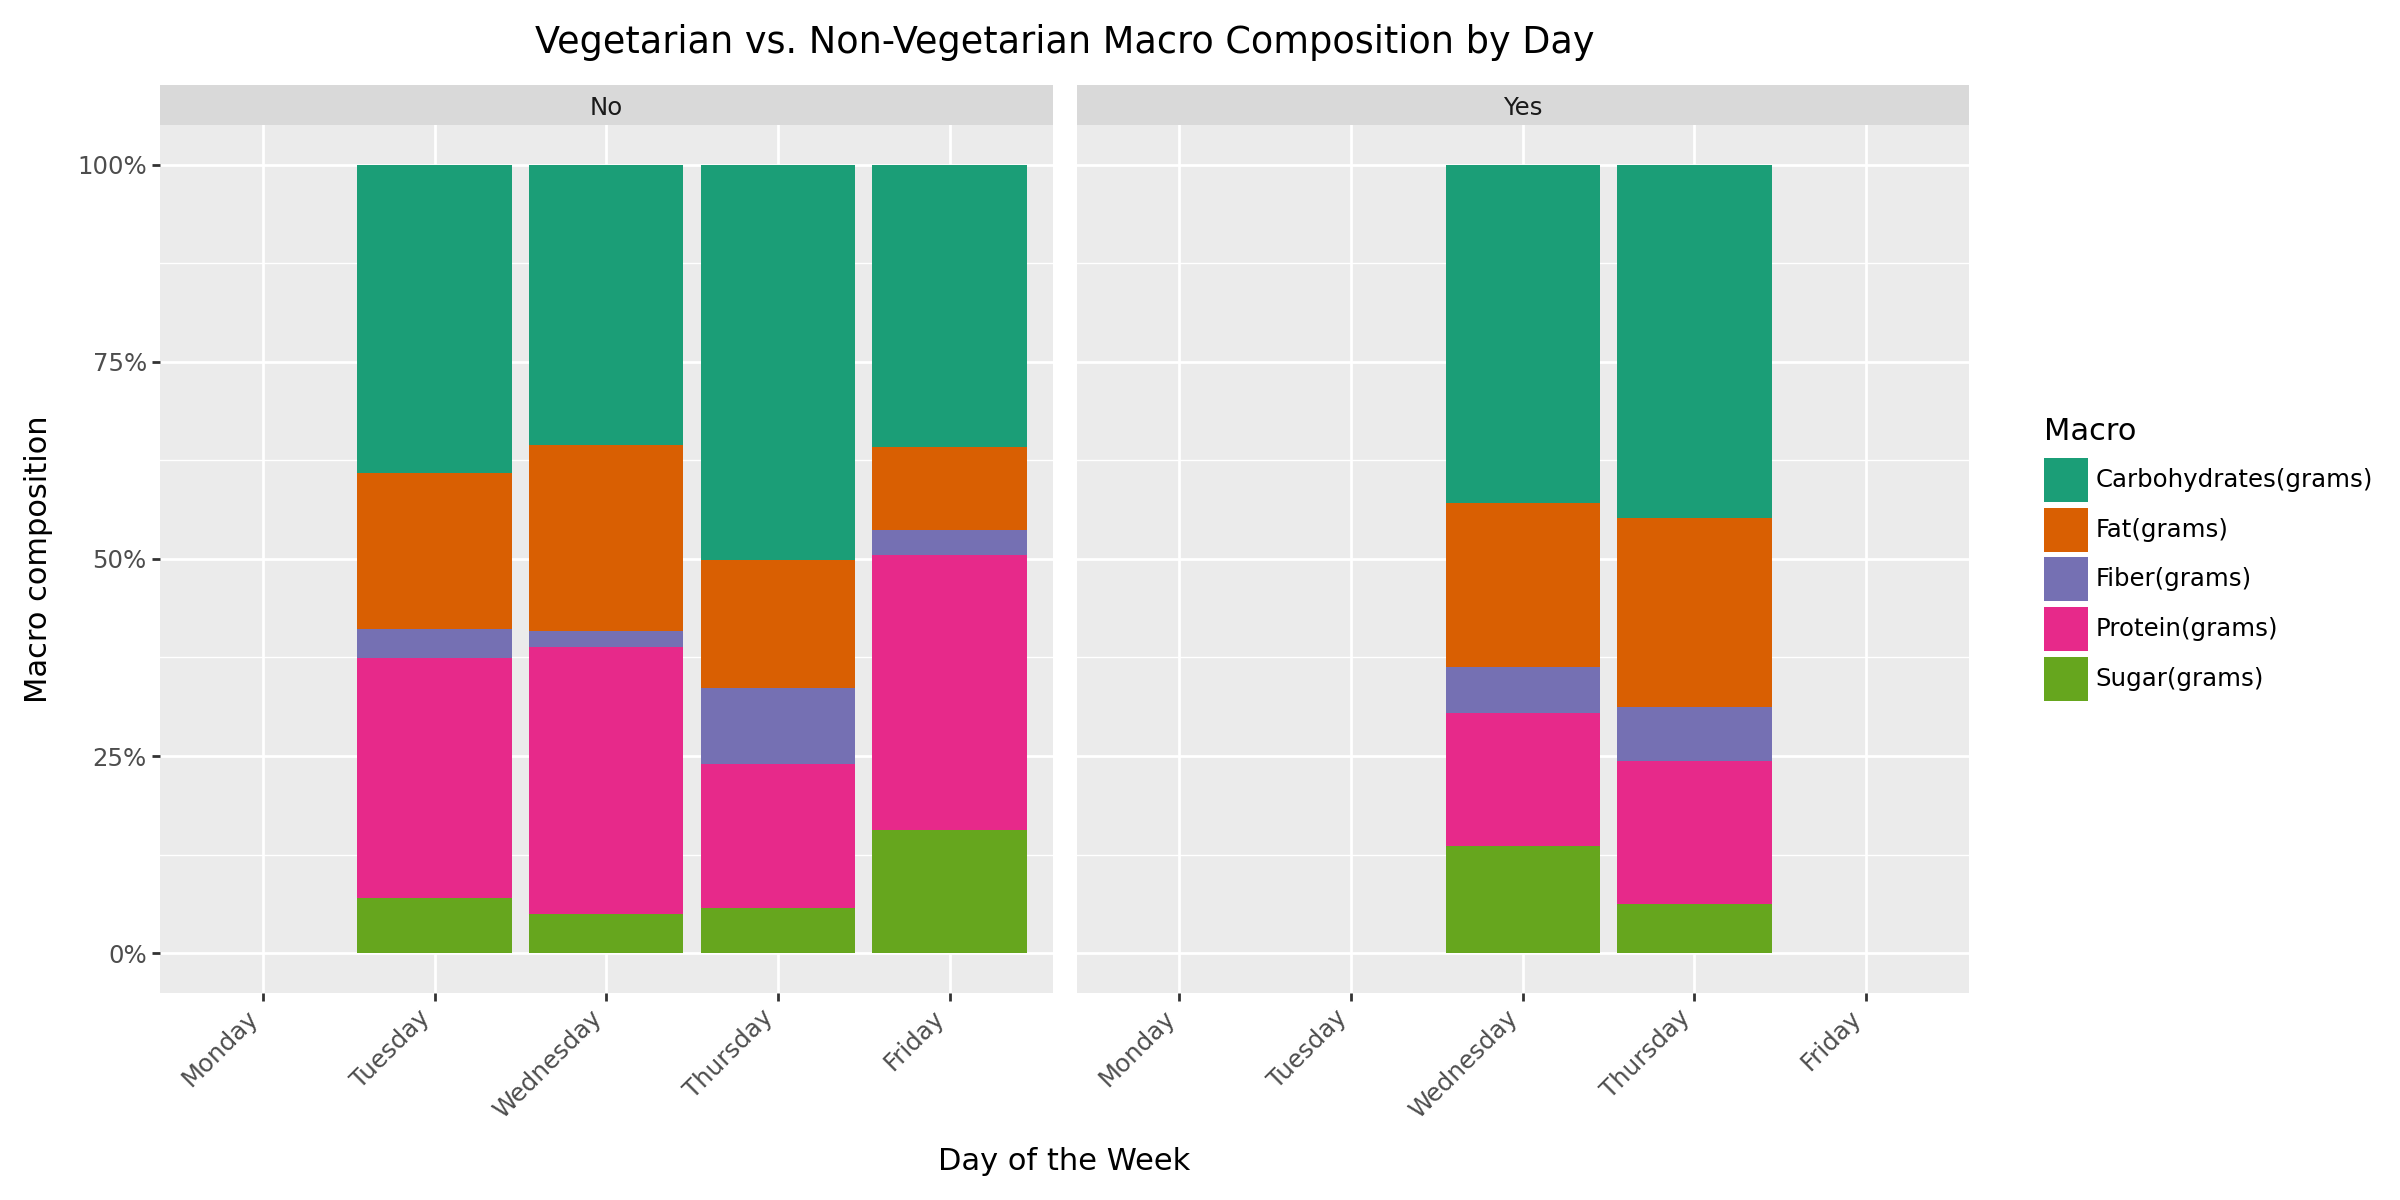

In [119]:
from plotnine import *

mealplan202 = df_all.copy()

macros_long = mealplan202.melt(
    id_vars=["Day of the Week", "Vegetarian?"],
    value_vars=["Protein(grams)", "Carbohydrates(grams)", "Fat(grams)", "Fiber(grams)", "Sugar(grams)"],
    var_name="Macro",
    value_name="grams"
)

macros_long["grams"] = pd.to_numeric(macros_long["grams"], errors="coerce") #makes grams column numeric
macros_long = macros_long.dropna(subset=["grams"]) #drops na values

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday"] #order of days of week
macros_long["Day of the Week"] = pd.Categorical(macros_long["Day of the Week"], categories=weekday_order, ordered=True) #makes categorical variable ordered in specified order i made

macros_long = macros_long.rename(columns={"Vegetarian?":"Vegetarian"}) #wasn't working properly with question mark in plotnine, needed to be removed

summary = macros_long.groupby(["Vegetarian","Day of the Week","Macro"], as_index=False)["grams"].sum() #groups by vegetarian or not, day of week, and macro and sums the grams

summary["prop"] = (summary.groupby(["Vegetarian","Day of the Week"])["grams"].transform(lambda x: x / x.sum())) #groups the newly made groups by vegetarian and day of week and
#take proportion of each macro to total macros for each day

#stacked bar chart of proportions
(
    ggplot(summary, aes(x="Day of the Week", y="prop", fill="Macro")) #day of week and proportion of macro filled by the macro
    + geom_col(position="stack") #stacked bar chart
    + scale_fill_brewer(type = 'qual', palette='Dark2') #used to change color of bars, like scale_fill_manual but i can choose theme/palette, need to use type = 'qual' to tell
    #plotnine that im using a categorical dataset
    + facet_wrap("~Vegetarian", ncol=2) #makes the facets and splits into two charts yes and no for the graphs
    + scale_y_continuous(labels=lambda l: [f"{int(v*100)}%" for v in l]) #lambda function to automatically make my proportions % by multiplying by 100 and adding %
    + labs(title="Vegetarian vs. Non-Vegetarian Macro Composition by Day", #adds titles to chart and axis
           x="Day of the Week", y="Macro composition", fill="Macro")
    + theme(axis_text_x=element_text(rotation=45, ha="right"),figure_size=(12, 6))
)